# Airbnb Hotel Booking Analysis — New York City
**Author:** MD Razeena Nishad  

**Project summary:**
Analyze Airbnb listings (NYC) to extract insights on pricing, availability, neighbourhood trends, and build a baseline price prediction model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style='whitegrid')


In [ ]:

DATA_URL = "https://voisfortech.com/storage/files/1730285881-Airbnb_Open_Data.xlsx"

try:
    df = pd.read_excel(DATA_URL, engine='openpyxl')
    print("Loaded dataset from URL:", DATA_URL)
except Exception as e:
    print("Failed to load directly from URL. Please download the file manually and upload as 'Airbnb_Open_Data.xlsx'")
    print("Error:", e)
    df = None

if df is not None:
    display(df.head())
    print('Shape:', df.shape)


Loaded dataset from URL: https://voisfortech.com/storage/files/1730285881-Airbnb_Open_Data.xlsx


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


Shape: (102599, 26)


## 1. Quick overview & missing values

In [4]:
if df is not None:
    display(df.head(5))
    print("Rows, Columns:", df.shape)
    display(df.dtypes.value_counts())
    missing = df.isnull().sum().sort_values(ascending=False)
    display(missing[missing > 0].head(20))
else:
    print("No dataset loaded.")

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


Rows, Columns: (102599, 26)


,count
float64,12
object,11
int64,2
datetime64[ns],1


,0
license,102597
house_rules,54843
last review,15893
reviews per month,15879
country,532
availability 365,448
minimum nights,409
host name,408
review rate number,326
calculated host listings count,319


## 2. Data cleaning & preprocessing

In [5]:
if df is not None:
    data = df.copy()
    # Standard price cleaning if column exists
    if 'price' in data.columns:
        data['price'] = data['price'].astype(str).str.replace('[\$,]', '', regex=True)
        data['price'] = pd.to_numeric(data['price'], errors='coerce')
    if 'last_review' in data.columns:
        data['last_review'] = pd.to_datetime(data['last_review'], errors='coerce')
    if 'reviews_per_month' in data.columns:
        data['reviews_per_month'] = data['reviews_per_month'].fillna(0)
    for col in ['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')
            data[col] = data[col].fillna(data[col].median())
    data = data.dropna(subset=[c for c in ['neighbourhood', 'room_type', 'price'] if c in data.columns])
    data = data[(data['price'] >= 1) & (data['price'] <= 2000)] if 'price' in data.columns else data
    print('After cleaning, rows:', data.shape[0])
else:
    data = None

After cleaning, rows: 102337


## 3. Exploratory Data Analysis (EDA)

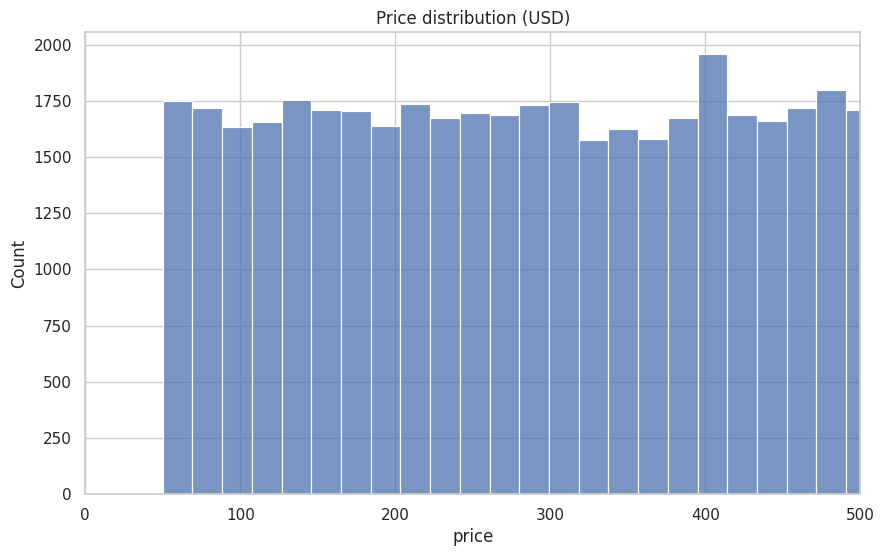

,price
count,102337.00
mean,625.28
std,331.68
min,50.00
25%,340.00
50%,624.00
75%,913.00
max,1200.00


In [6]:
if data is not None and 'price' in data.columns:
    plt.figure()
    sns.histplot(data['price'], bins=60)
    plt.title('Price distribution (USD)')
    plt.xlim(0,500)
    plt.show()
    display(data['price'].describe().round(2))
else:
    print('No price column available or no data loaded.')

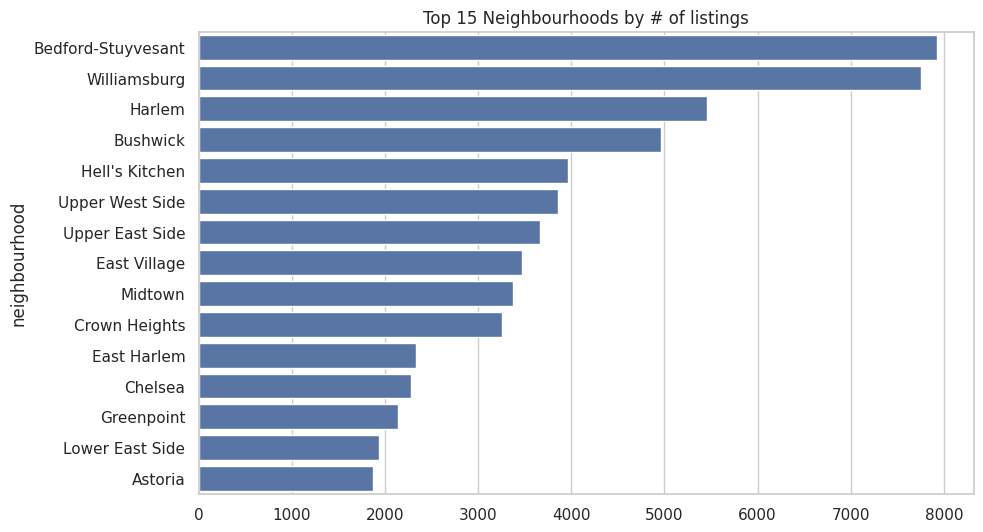

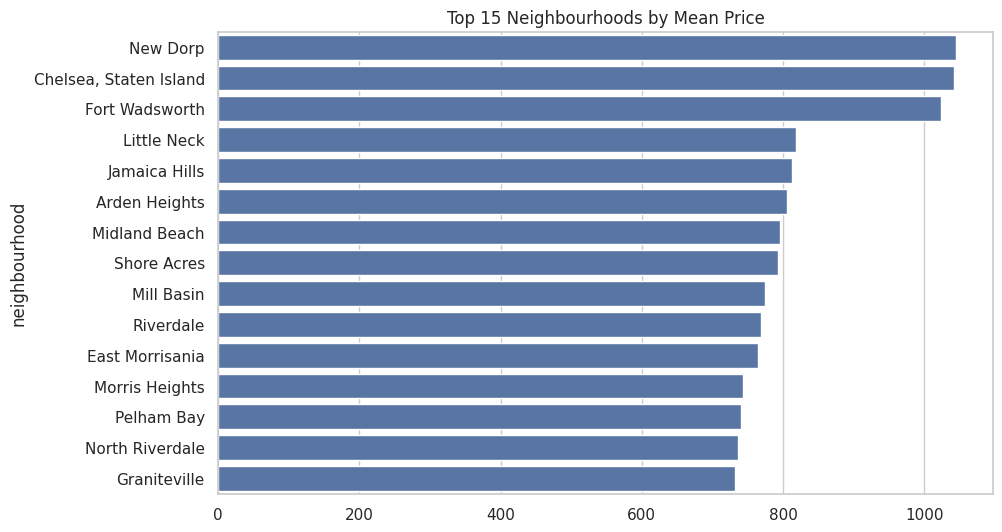

In [7]:
if data is not None and 'neighbourhood' in data.columns:
    nb_counts = data['neighbourhood'].value_counts().head(15)
    plt.figure()
    sns.barplot(y=nb_counts.index, x=nb_counts.values)
    plt.title('Top 15 Neighbourhoods by # of listings')
    plt.show()
    mean_price = data.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).head(15)
    plt.figure()
    sns.barplot(x=mean_price.values, y=mean_price.index)
    plt.title('Top 15 Neighbourhoods by Mean Price')
    plt.show()


In [11]:
if data is not None and 'room_type' in data.columns:
    plt.figure()
    sns.countplot(y='room_type', data=data, order=data['room_type'].value_counts().index)
    plt.title('Room type counts')
    plt.show()
    plt.figure()
    sns.boxplot(x='room_type', y='price', data=data)
    plt.ylim(0,500)
    plt.title('Price by room type (boxplot)')
    plt.show()


## 4. Feature engineering & baseline models

Linear Regression MAE: 287.3
Random Forest MAE: 209.2


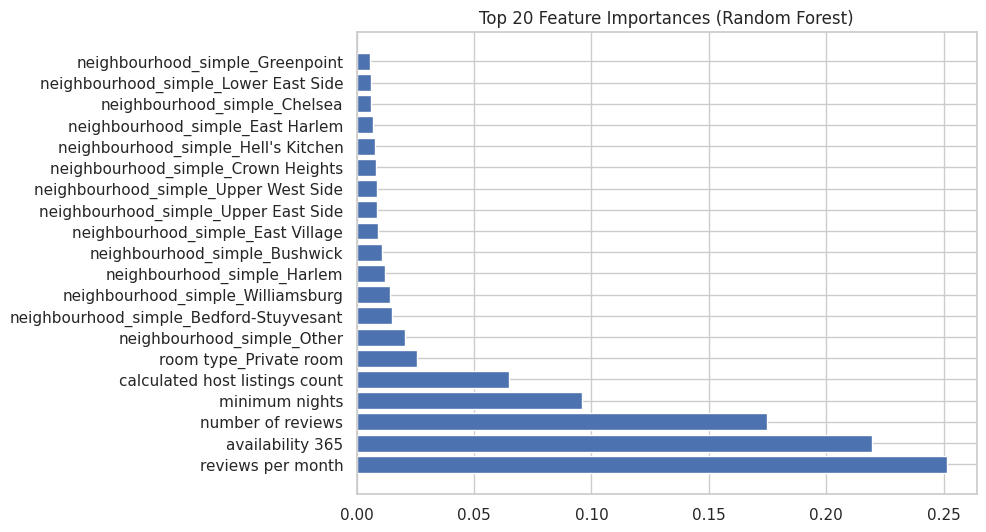

In [14]:

if data is not None and 'price' in data.columns:
    df_model = data[[
        'price',
        'neighbourhood',
        'room type',
        'minimum nights',
        'number of reviews',
        'reviews per month',
        'availability 365',
        'calculated host listings count'
    ]].copy()

    top_n = 20
    top_nebs = df_model['neighbourhood'].value_counts().nlargest(top_n).index
    df_model['neighbourhood_simple'] = df_model['neighbourhood'].where(df_model['neighbourhood'].isin(top_nebs), 'Other')

    df_model = pd.get_dummies(df_model, columns=['neighbourhood_simple', 'room type'], drop_first=True)


    df_model = df_model.dropna()

    X = df_model.drop(columns=['price','neighbourhood'])
    y = df_model['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lr = LinearRegression().fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    print('Linear Regression MAE:', round(mean_absolute_error(y_test, y_pred_lr), 2))

    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    print('Random Forest MAE:', round(mean_absolute_error(y_test, y_pred_rf), 2))

    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    plt.barh(importances.index, importances.values)
    plt.title('Top 20 Feature Importances (Random Forest)')
    plt.show()

else:
    print('No suitable data for modeling.')


In [12]:
print("Columns in your dataset:")
for col in data.columns:
    print(col)


Columns in your dataset:
id
NAME
host id
host_identity_verified
host name
neighbourhood group
neighbourhood
lat
long
country
country code
instant_bookable
cancellation_policy
room type
Construction year
price
service fee
minimum nights
number of reviews
last review
reviews per month
review rate number
calculated host listings count
availability 365
house_rules
license


## 5. Export results

Saved neighbourhood_summary.csv and top_neighbourhoods.png


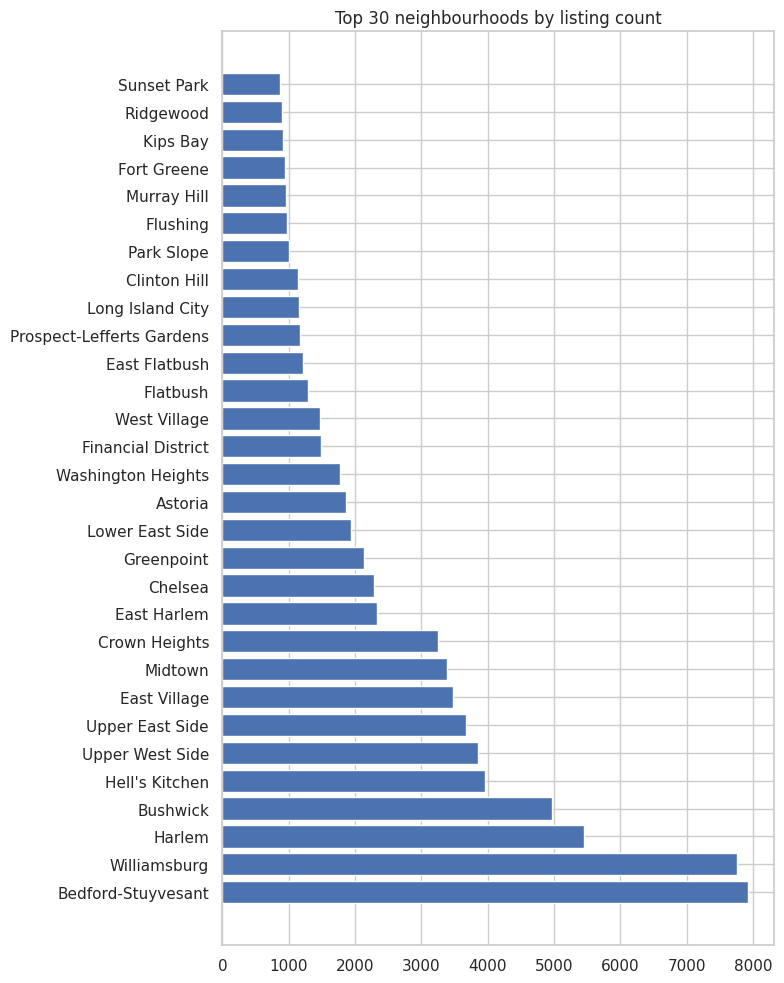

In [16]:
if data is not None:
    nb_summary = data.groupby('neighbourhood').agg({
        'price': ['mean','median','count'],
        'availability 365': 'mean'   # <-- fixed name here
    }).reset_index()

    nb_summary.columns = ['neighbourhood','mean_price','median_price','count','mean_availability']
    nb_summary_sorted = nb_summary.sort_values('count', ascending=False).head(30)

    nb_summary_sorted.to_csv('neighbourhood_summary.csv', index=False)

    plt.figure(figsize=(8,10))
    plt.barh(nb_summary_sorted['neighbourhood'], nb_summary_sorted['count'])
    plt.title('Top 30 neighbourhoods by listing count')
    plt.tight_layout()
    plt.savefig('top_neighbourhoods.png', dpi=150)

    print('Saved neighbourhood_summary.csv and top_neighbourhoods.png')
else:
    print('No data to export.')


## Conclusions & Next Steps

- Price distribution is right-skewed; many listings under $200.
- Room type and neighbourhood strongly influence price.
- Next steps: add location-based features, seasonality, hyperparameter tuning, and build a dashboard (Streamlit/Flask).